In [2]:
import local_utils
import os
import flopy
import numpy as np
import sys
from pathlib import Path
from scipy.io import savemat

datadir = Path('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/heterog_1000/MC_expt_2020-02-01-18-15')

In [3]:
# ucn_dict = local_utils.create_ucn_from_dir(datadir,totims = (1,180,360), ftype='mat')
# local_utils.save_obj(datadir,ucn_dict,'ucn_dict')
varlist_final = local_utils.load_obj(datadir,'varlist_final')
varlist = varlist_final
# savemat(datadir.joinpath('varlist_final.mat'),varlist_final)

In [44]:
def create_CF_from_dir(dirname,ucn_dict=None,
                   modsize = (26,20,100),
                   varlist=None,
                   ftype='mat',
                   saveyn=True):
    
    import simulationFFT
    Lx = 3000.
    Ly = 600.
    Lz = 80.

    nlay,nrow,ncol = modsize
    delv,delc,delr = (3,30,30)


    if varlist is None:
        varlist = local_utils.load_obj(datadir,'varlist_final')
    if ucn_dict is None:
        try:
            ucn_dict = local_utils.load_obj(datadir,'ucn_dict')
        except:
            ucn_dict = local_utils.create_ucn_from_dir(datadir,totims = (1,180,360), saveyn=False)

    CF_mat = {}
    for it in ucn_dict.keys():
        CF_glob = varlist['CF_glob'][it]
        CF_var = varlist['CF_var'][it]
        seed = varlist['seed'][it]
        hk_mean = varlist['hk_mean'][it]
        hk_var = varlist['hk_var'][it]
        por_mean = varlist['por_mean'][it]
        por_var = varlist['por_var'][it]
        corr_len = varlist['corr_len'][it]
        corr_len_yx = varlist['corr_len_yx'][it]
        corr_len_zx = varlist['corr_len_zx'][it]
        clay_lyr_yn = varlist['clay_lyr_yn'][it]
        vario_type = varlist['vario_type'][it]

        #Create Gaussian Simulation
        lcol = int(corr_len/delr)
        llay = int(corr_len*corr_len_zx/delv)
        lrow = int(corr_len*corr_len_yx/delc)
        CF_mat['CF{}'.format(it)] = simulationFFT.simulFFT(nrow,nlay, ncol,CF_glob,
                                            CF_var,vario_type, lrow ,
                                            llay, lcol,seed=seed)
    if saveyn:
        if ftype=='mat':
            savemat(dirname.joinpath('CF_mat.mat'),CF_mat, do_compression=True)
            print('saved {}'.format(dirname.joinpath('CF_mat.mat')))
        elif ftype=='npy':
            for k,v in CF_mat.items():
                np.save(dirname.joinpath('CF_mat{}.npy'.format(k)),v)
                print('saved {}'.format(dirname.joinpath('conc_mat{}.npy'.format(k))))
        else:
            raise(Exception('allowed ftypes: "mat", "npy"'))
    return CF_mat


In [3]:
# CF_mat = local_utils.create_CF_from_dir(datadir,saveyn=False)


import matplotlib.pyplot as plt
plt.imshow(CF_mat['CF0'][:,0,:])
plt.colorbar()

dict_keys(['CF0', 'CF10', 'CF1', 'CF2'])

In [39]:
str_start='it'
str_end = '.pkl'
aemdir = datadir.joinpath('aem')
import glob

fnames = sorted(glob.glob(Path(aemdir).joinpath('*.pkl').as_posix()))
fnames_part = [Path(f).name for f in fnames]
aem_dict ={}
for f in fnames_part:
    start_ind, stop_ind  = f.find(str_start),f.find(str_end)
    aem_dict[int(f[start_ind+len(str_start):stop_ind])] = f


In [42]:
rmFailed=True
ftype = 'mat'
saveyn = False
dirname = datadir
if rmFailed:
    rmlist = []
    if varlist is None:
        try:
            varlist = load_obj(dirname, 'varlist_final')
        except:
            raise(Exception('Cannot find "varlist"'))
    for ind in ucn_dict.keys():
        if varlist['success'][ind]!=1:
            rmlist.append(ind)
    if len(rmlist)>0:
        rmdir = dirname.joinpath('removed')
        if not rmdir.exists():
            rmdir.mkdir()
        for rm_ind in rmlist:
            if not rmdir.joinpath(ucn_dict[rm_ind]).exists():
                dirname.joinpath(ucn_dict[rm_ind]).replace(rmdir.joinpath(ucn_dict[rm_ind]))
            del ucn_dict[rm_ind]
            print('removed failed iteration from concentration dict: {}\n'.format(rm_ind))
    else:
        print('No failed iterations found')

AEM_mat = {}
for k,v in aem_dict.items():
    AEM_mat['AEM_mat{}'.format(k)] = np.asarray(local_utils.load_obj(aemdir,v[:-4]))
    
if saveyn:
    if ftype=='mat':
        savemat(aemdir.joinpath('AEM_mat.mat'),AEM_mat,  do_compression=True)
        print('saved {}'.format(aemdir.joinpath('AEM_mat.mat')))
    elif ftype=='npy':
        for k,v in AEM_mat.items():
            np.save(aemdir.joinpath('AEM_mat{}.npy'.format(int(k[7:]))),v)
            print('saved {}'.format(dirname.joinpath('AEM_mat{}.npy'.format(int(k[8:])))))
        np.save(aemdir.joinpath('conc_mat_totims.npy'),np.asarray(totims))


No failed iterations found


In [3]:
base_case_dir = Path('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/homog')

m = flopy.seawat.Seawat.load(base_case_dir.joinpath('homog.nam').as_posix())
yxz = m.dis.get_node_coordinates()
local_utils.save_obj(datadir,yxz,'yxz')

In [14]:
from scipy.io import loadmat

dirname = datadir
yxz = local_utils.load_obj(datadir,'yxz')

try:
    len(conc_mat)
except:
    conc_mat = loadmat(datadir.joinpath('conc_mat.mat'))
    rmfield =[]
    for k in conc_mat.keys():
        if (k.startswith('__') or k.startswith('times')):
            rmfield.append(k)
    for k in rmfield:
        del conc_mat[k] 

In [25]:
import hausdorff_from_dir_PC

hdorf_matdict = {}
Csalt = 35.0001
Cfresh = 0
pct = (.05,.95)
pct50 = (Csalt+Cfresh)/2
tol = .20 #percentage
dirname=Path(dirname)
mname = dirname.parts[-2]


from skimage import measure
idx_dict = {}
face_dict = {}
if pct is None:
    pct = (.05,.95)
totims = 4
t= 0

for i,v in conc_mat.items():
#     print('it',i,'time',t)
    idx_dict[i] = np.where((v[t]<pct50*(1+tol)) & (v[t]>pct50*(1-tol)))
    faces = []
    for p in pct:
        verts, f, normals, values = measure.marching_cubes_lewiner(v[t],(Csalt+Cfresh)*p)
        faces.append(f[np.arange(1,len(f),3),:])
    face_dict[i] = list(map(tuple, np.vstack(faces)))

ptset_dict = {}
for k,v in idx_dict.items():
    ptset_tuple = hausdorff_from_dir_PC.idx2centroid(yxz,v)
    ptset_dict[i] = [(ptset_tuple[0][i],ptset_tuple[1][i],ptset_tuple[2][i]) for i in range(len(ptset_tuple[0]))]

for i,(k,v) in enumerate(idx_dict.items()):
    print('Calculating hausdorff for  ',i,k)
    for j,(k2,v2) in enumerate(idx_dict.items()):
        if j<=i:
            continue
        #hdorf_list.append(mod_hausdorff(ptset_dict[j],ptset_dict[i]))
        hdorf_list.append(hausdorff_from_dir_PC.mod_hausdorff(face_dict[k2],face_dict[k]))
        hdorf_mat[i,j] = hdorf_list[-1]
hdorf_mat = hdorf_mat + hdorf_mat.T
savemat(datadir.joinpath('hdorf_conc.mat'),{'D':hdorf_mat})

    

In [41]:
hdorf_list.append(hausdorff_from_dir_PC.mod_hausdorff(face_dict[k2],face_dict[k]))

k2

[0.0, 0.0, 0.0]

In [61]:
datadir

PosixPath('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/heterog_1000/MC_expt_2020-02-01-18-15')

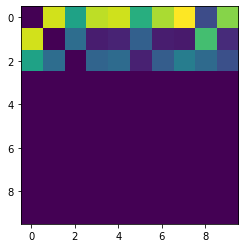

In [48]:
from matplotlib.pyplot import imshow
imshow(hdorf_mat[:10,:10])

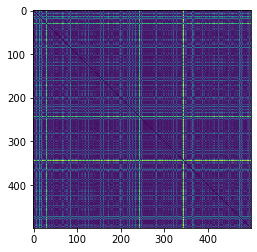

In [60]:

# hdorf_mat = np.triu(hdorf_mat)
imshow(hdorf_mat)



In [15]:
conc_mat = loadmat(datadir.joinpath('conc_mat.mat'))
rmfield =[]
for k in conc_mat.keys():
    if (k.startswith('__') or k.startswith('times')):
        rmfield.append(k)
for k in rmfield:
    del conc_mat[k] 

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


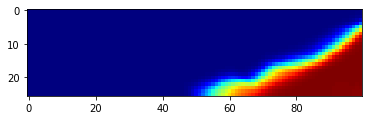

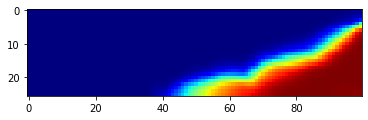

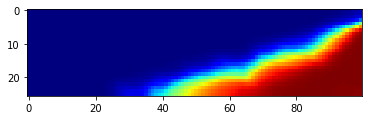

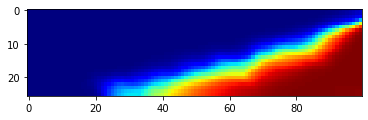

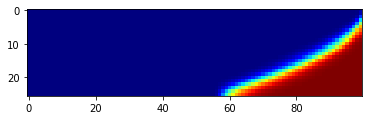

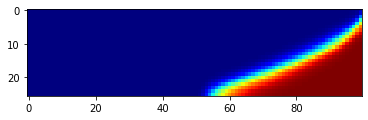

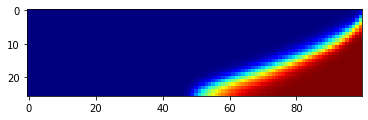

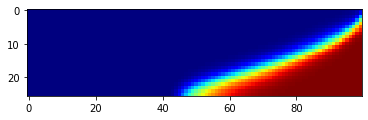

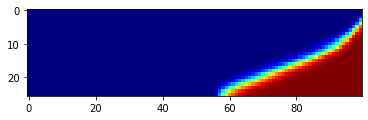

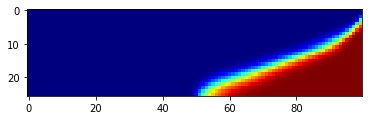

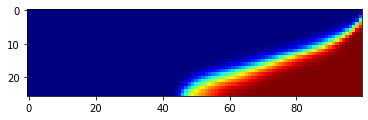

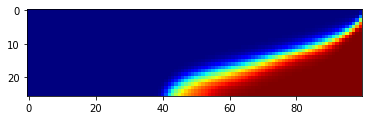

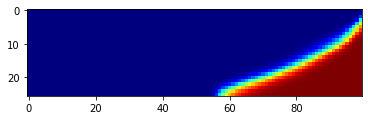

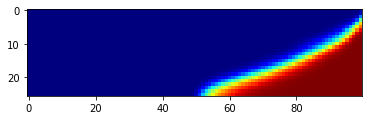

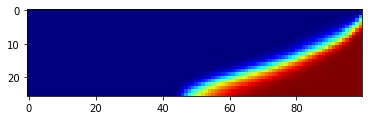

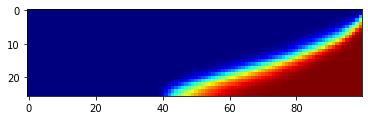

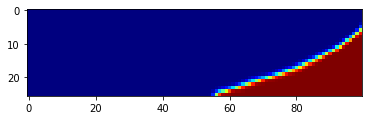

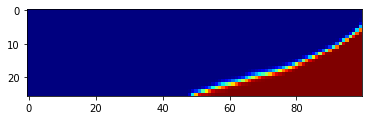

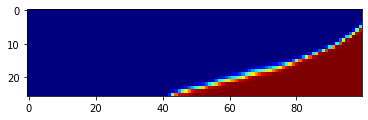

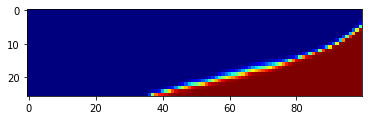

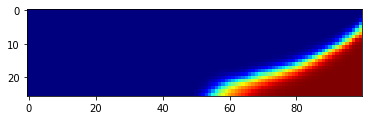

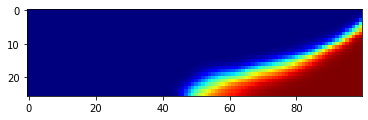

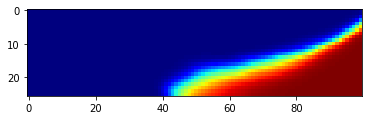

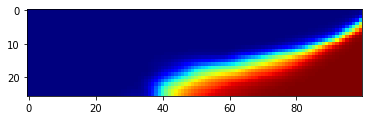

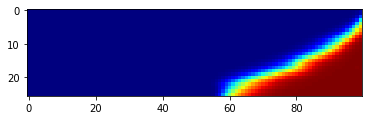

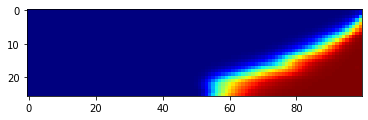

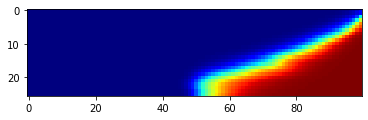

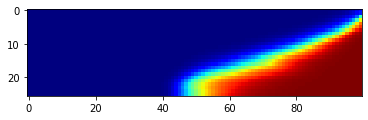

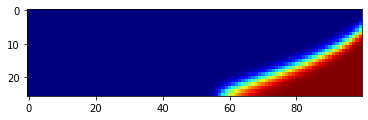

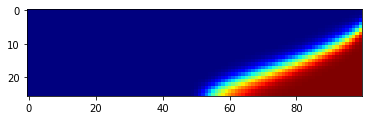

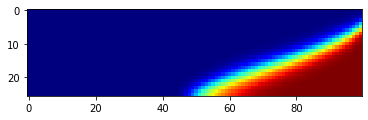

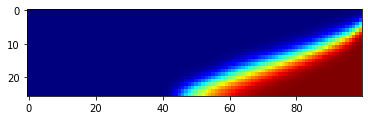

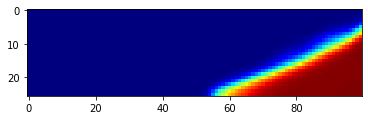

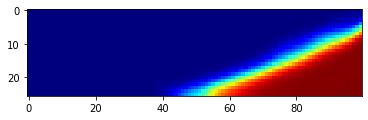

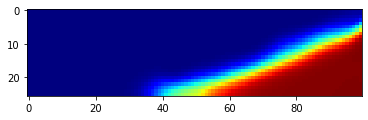

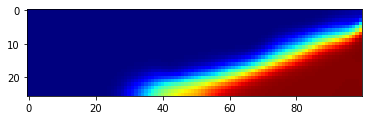

In [20]:
import matplotlib.pyplot as plt
i = 0
n_it = 10
rowslice= 13
for k,v in conc_mat.items():
    i+=1
    if i>=n_it:
        break
    for t in range(4):
        f,ax =plt.subplots(1,figsize=(6,4))
    #     v[np.logical_or(v>10000,v>100000)]=np.nan
        plt.imshow(v[t,:,rowslice,:],cmap='jet')
        plt.savefig(datadir.joinpath('conc_mat{}_{}.png'.format(t,i)),dpi=300,bbox_inches='tight')

In [23]:
import hausdorff_from_dir_PC
hausdorff_from_dir_PC.mod_hausdorff??

Signature: hausdorff_from_dir_PC.mod_hausdorff(u, v)
Docstring: <no docstring>
Source:   
def mod_hausdorff(u,v):
    from scipy.spatial.distance import directed_hausdorff
    return max(directed_hausdorff(u,v)[0], directed_hausdorff(v,u)[0])
File:      ~/Documents/ProjectsLocal/SWIsmall/notebook/hausdorff_from_dir_PC.py
Type:      function


In [ ]:
def compute_export_hausdorff(dirname,conc_mat=None,yxz=None,inputParams=None,saveyn=1,pct=(.05,.95),suffix=''):
    hdorf_matdict = {}
    Csalt = 35.0001
    Cfresh = 0
    pct50 = (Csalt+Cfresh)/2
    tol = .20 #percentage
    dirname=Path(dirname)
    mname = dirname.parts[-2]

    try:
        m = flopy.modflow.Modflow.load(str(dirname.parent.joinpath(mname + '.nam')))
    except:
        print('cant load modflow model... assuming model is size 26x20x100')
        m = flopy.modflow.Modflow('temp')
        flopy.modflow.ModflowDis(m, 26,20,100)

    #Load a conc_mat from .npy files in directory if not specified
    if conc_mat is None:
        conc_mat = conc_mat_from_dir(dirname,m)
        
    from skimage import measure
    idx_dict = {}
    face_dict = {}
    if pct is None:
        pct = (.05,.95)
    for i in range(len(conc_mat)):
        print('it',i)
        idx_dict[i] = np.where((conc_mat[i]<pct50*(1+tol)) & (conc_mat[i]>pct50*(1-tol)))
        faces = []
        for p in pct:
            verts, f, normals, values = measure.marching_cubes_lewiner(conc_mat[i],(Csalt+Cfresh)*p)
            faces.append(f[np.arange(1,len(f),3),:])
        face_dict[i] = list(map(tuple, np.vstack(faces)))


    #Filter out keys that have errors and make new dict with filled sequential keys
    filt_mat = np.where(conc_mat>1e10,np.nan,conc_mat) #get rid of region above water table (value = 1e30)
    filt = [k for k, v in idx_dict.items() if len(v[0])==0 #which indicies to get rid of
        or (filt_mat[k].max() > Csalt*1.05)
        or (filt_mat[k].min() < -.1)]
    
    idx_dict_filt = filter_dict(idx_dict,filt)
    face_dict_filt = filter_dict(face_dict,filt)
    
    '''
    i=0
    idx_dict_filt = {}
    for k,v in idx_dict.items():
        if k in filt:
            print('iteration ',k,'doesnt meet reqs and will be filtered out')
        else:
            idx_dict_filt[i] = v
            i+=1

    i=0
    face_dict_filt = {}
    for k,v in face_dict.items():
        if k in filt:
            print('iteration ',k,'doesnt meet reqs and will be filtered out')
        else:
            face_dict_filt[i] = v
            i+=1
    '''

    try:
        #Do the same with inputParams dictionary
        if inputParams is None:
            inputParams = load_obj(dirname,'inputParams_success')
        inputParams_filt,N = filter_inputParams(inputParams,filt)
        ''' 
        i=0
        inputParams_filt = {}
        for k,v in m.inputParams.items():
            vnew = [x for i, x in enumerate(v) if i not in filt]
            inputParams_filt[k] = vnew
            if i==0:
                N = len(vnew)
            i+=1
        '''
            
        ParametersValues = np.zeros((N,len(inputParams_filt)))
        for i,key in enumerate(inputParams_filt):
            ParametersValues[:,i] = np.asarray(inputParams_filt[key])
        hdorf_matdict['InputParams'] = inputParams_filt #Dict of the names and values, mostly for error checking
        hdorf_matdict['ParametersValues'] = ParametersValues
    except:
        print('Not able to import inputParams.pkl, cannot export inputParams file')
        pass

    #create pointset dictionary: (x1,y1,z1),...
    #   from the numpy tuple format: (x1,x2,...),(y1,y2,...),(z1,z2,...)
    if yxz is None:
        yxz = m.dis.get_node_coordinates()
    ptset_dict = {}
    for i in range(len(idx_dict_filt)):
        print('iteration',i)
        ptset_tuple = idx2centroid(yxz,idx_dict_filt[i])
        ptset_dict[i] = [(ptset_tuple[0][i],ptset_tuple[1][i],ptset_tuple[2][i]) for i in range(len(ptset_tuple[0]))]

    hdorf_mat = np.zeros((len(idx_dict_filt),len(idx_dict_filt)),dtype=float)
    hdorf_list= []
    for i in range(len(idx_dict_filt)):
        for j in range(i+1,len(idx_dict_filt)):
            #hdorf_list.append(mod_hausdorff(ptset_dict[j],ptset_dict[i]))
            hdorf_list.append(mod_hausdorff(face_dict_filt[j],face_dict_filt[i]))
            hdorf_mat[i,j] = hdorf_list[-1]
            print('Calculating hausdorff row ',i,' col ',j)
    hdorf_mat = hdorf_mat + hdorf_mat.T
    hdorf_matdict['hausdorff_mat'] = hdorf_list #list of distance calculations (not squareformed)
    hdorf_matdict['culled_conc_mat'] = np.delete(conc_mat, filt, 0)
    #Save hausdorff matrix, Input Parameter Values
    if saveyn==1:
        np.save(dirname.joinpath('hausdorff'+str(suffix)+'.npy'),hdorf_list)
        savemat(dirname.joinpath('hausdorff'+str(suffix)+'.mat').as_posix(),hdorf_matdict)
        print('...saved!')
        return
    else:
        return hdorf_matdict,conc_mat
